# Machine Learning and Time Series Analysis for Brain Signals

January 17th 2019

Andrea Insabato

https://andreainsabato.eu

Universitat Pompeu Fabra

## Acknowledgments

* Matthieu Gilson

* Vicente Pallarés

## Libraries used:
* Scipy, Numpy, Matplotlib
* NetworkX: network construction and manipulation
* Scikit-learn: Machine Learning
* Pandas + Seaborn: cool graphics

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from scipy.stats import pearsonr, ttest_ind
from sklearn.covariance import GraphicalLassoCV
from sklearn.model_selection import KFold, ShuffleSplit
from conn_utils import make_chain, make_common_input, make_full, make_rnd_connectivity, MOU
sns.set_context('poster')
plt.rcParams['figure.figsize'] = (15, 8)
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Brain signals

<img src="brain_signals.jpeg" alt="spatio-temporal resolution of brain signals" width="800"/>
<small>from Sejnowski et al. (Nat. Neuro. 2014)<small>

## Some questions about the brain 

* Which brain areas are involved in cognitive (dis-)function X?
* What is the connectivity pattern underlying (dis-)function X?
* What is the activity of neurons in (dis-)function X?
* What is the mechanism underlying (dis-)function X?
* How do neuron encode and communicate information?
* How does complex behavior emerges from simpler cognitive functions?

## Some questions about the brain 

* Which brain areas are involved in cognitive (dis-)function X?
* <span style="color:red">__What is the connectivity pattern underlying (dis-)function X?__</span>
* What is the activity of neurons in (dis-)function X?
* What is the mechanism underlying (dis-)function X?
* How do neuron encode and communicate information?
* How does complex behavior emerges from simpler cognitive functions?

## Brain connectivity

* __structural__: Represents anatomical connections between brain regions. Inferred from structural MRI (3D data).

* __functional__: Represents the comminication between brain regions. Inferred from BOLD fMRI signals (4D data, time series).

* __effective__: Comes from BOLD fMRI as well but is inferred by fitting a network model to the data.

## Brain connectivity

* model-free
* model-based

### All measures require modeling assumption

## Anscombe quartet

A recurrent discussion about connectivity measures is that about model-free versus model-based approaches. 

Our viewpoint is that, even though measures can be calculated without explicitly assuming a model, __their interpretation is always related to a model__.

To illustrate this point in a simple bivariate case we reproduce Anscombe's quartet, that shows assumptions underlying Pearson's correlation and their violations.

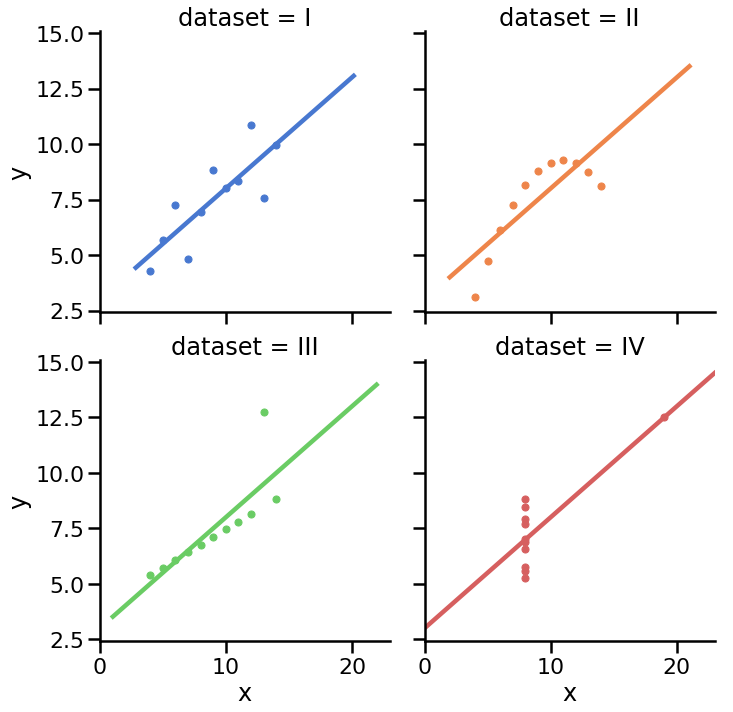

In [2]:
anscombe = sns.load_dataset('anscombe')
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=anscombe,
           col_wrap=2, ci=None, palette="muted", scatter_kws={"s": 50, "alpha": 1})
plt.show()

In all four panels the coefficient is the same but only the top left panel shows the distribution of data that we would expect if we are told that $\rho=0.816$.

Dataset I has gaussian variables with linear dependence. Dataset II shows non linear dependence between y and x. Dataset III has a perfect linear relation but the estimates are off because of the presence of one outlier in the dependent variable. Dataset IV shows no relation between x and y but an apparently strong regression line due to one outlier in both the dependent and independent variable.


## Brain connectivity

* causal
* non-causal

## Causal interactions

__Minimal requirements__:

* directionality
* sparseness

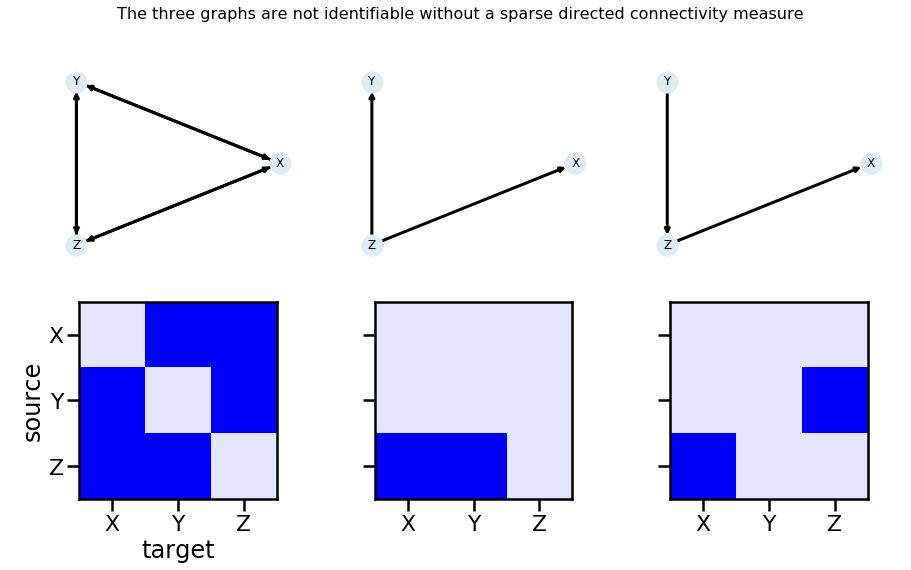

In [3]:
chain = make_chain()
common_drive = make_common_input()
full = make_full()

plt.rcParams['figure.figsize'] = (15, 8)
drawing_options = {
'node_color': '#e0ecf4',
'node_size': 400,
'width': 3,
}
colmap = sns.light_palette("blue", as_cmap=True)
plt.suptitle("The three graphs are not identifiable without a sparse directed connectivity measure", fontsize=16)
plt.subplot(2, 3, 1)
nx.draw_circular(full, with_labels=True, **drawing_options)
plt.subplot(2, 3, 2)
nx.draw_circular(common_drive, with_labels=True, **drawing_options)
plt.subplot(2, 3, 3)
nx.draw_circular(chain, with_labels=True, **drawing_options)
plt.subplot(2, 3, 4)
plt.imshow(nx.to_numpy_matrix(full), cmap=colmap)
plt.yticks([0, 1, 2], ['X', 'Y', 'Z'])
plt.xticks([0, 1, 2], ['X', 'Y', 'Z'])
plt.ylabel('source')
plt.xlabel('target')
plt.subplot(2, 3, 5)
plt.imshow(nx.to_numpy_matrix(common_drive), cmap=colmap)
plt.yticks([0, 1, 2], [])
plt.xticks([0, 1, 2], ['X', 'Y', 'Z'])
plt.subplot(2, 3, 6)
plt.imshow(nx.to_numpy_matrix(chain), cmap=colmap)
plt.yticks([0, 1, 2], [])
plt.xticks([0, 1, 2], ['X', 'Y', 'Z'])
plt.show()

Three different graphs and their associated adjacency matrices. 
Left: fully connected graph. 
Center: Z is the common input to both X and Y. 
Right: chain from Y to X through Z. 

A connectivity measure unable to estimate a sparse matrix cannot distinguish the three cases: all estimates would look like the one on the left. A non-directed measure would be unable to distinguish between the chain and the common input: both estimated matrices would be symmetric.

## Estimation of connectivity with synthetic data

* generated with a multivariate Ornstein-Uhlenbeck model
* sparse and directed graph
    * $A \sim Bern(p=0.2)$
    * $log(W) \sim \mathcal{N}(0,1)$
    * $EC = A \otimes W$

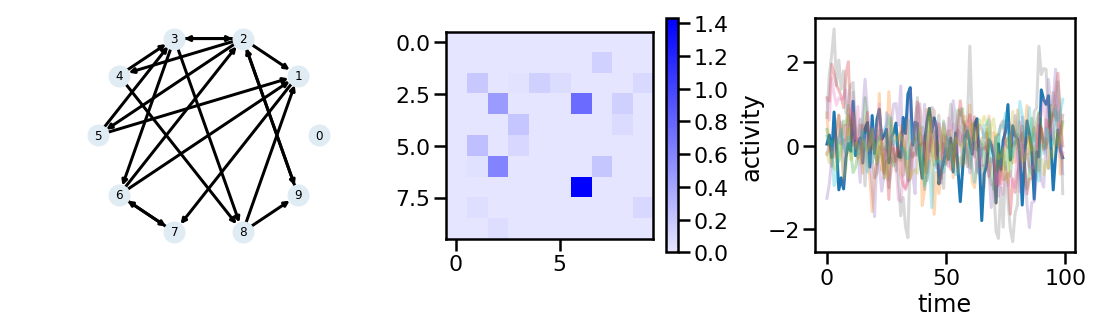

In [4]:
# generate connectivity matrix
n = 10
EC = make_rnd_connectivity(n=n)
G = nx.from_numpy_array(EC, create_using=nx.DiGraph())
plt.subplot(2,3,1)
nx.draw_circular(G, with_labels=True, **drawing_options)
plt.subplot(2,3,2)
plt.imshow(EC, cmap=colmap)
plt.colorbar()
# generate data with MOU
generator = MOU(n_nodes=n, C=EC)
TS = generator.simulate(T=1000, random_state=0)
plt.subplot(2,3,3)
plt.plot(TS[:min(100, 1000), 0])
plt.plot(TS[:min(100, 1000), 1:], alpha=0.3)
plt.xlabel('time')
plt.ylabel('activity')
plt.tight_layout()
plt.show()

## Estimation: Pearson's correlation, partial correlation, mOU

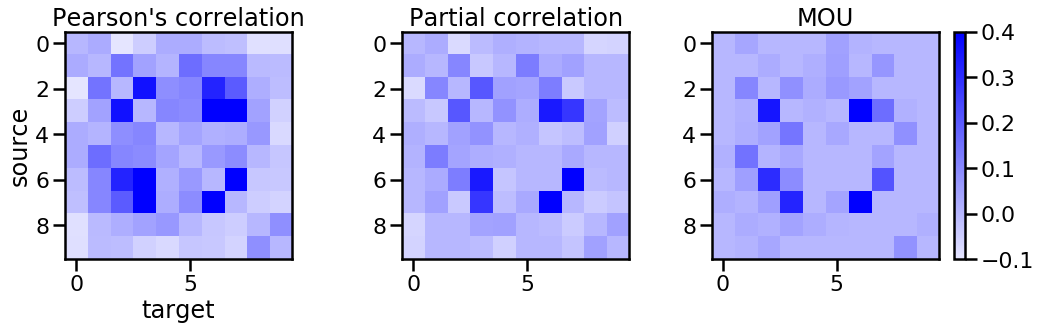

In [5]:
# estimate connectivity with Pearson's correlation, partial correlation, MOU
FC = np.corrcoef(TS.T)
np.fill_diagonal(FC, 0)
glasso = GraphicalLassoCV(cv=3)
glasso.fit(TS)
precision = glasso.precision_
prec_diag = np.diagonal(precision)
PC = - precision / np.sqrt(np.outer(prec_diag, prec_diag))
np.fill_diagonal(PC, 0)
mOU = MOU(n_nodes=n)
mOU.fit(TS)
C = mOU.C
plt.subplot(2,3,4)
plt.imshow(FC, cmap=colmap)
plt.clim([-.1, .4])
plt.title('Pearson\'s correlation')
plt.xlabel('target')
plt.ylabel('source')
plt.subplot(2,3,5)
plt.imshow(PC, cmap=colmap)
plt.clim([-.1, .4])
plt.title('Partial correlation')
plt.subplot(2,3,6)
plt.imshow(C, cmap=colmap)
plt.colorbar()
plt.clim([-.1, .4])
plt.title('mOU')
plt.tight_layout()
plt.show()

## Further readings

* Matthieu's webpage: https://matthieugilson.eu


* Gilson et al. (PLoS Comp. Biol., 2016)  

## Real data

* 22 subjects
* 2 conditions: resting state, movie viewing
* 66 brain regions

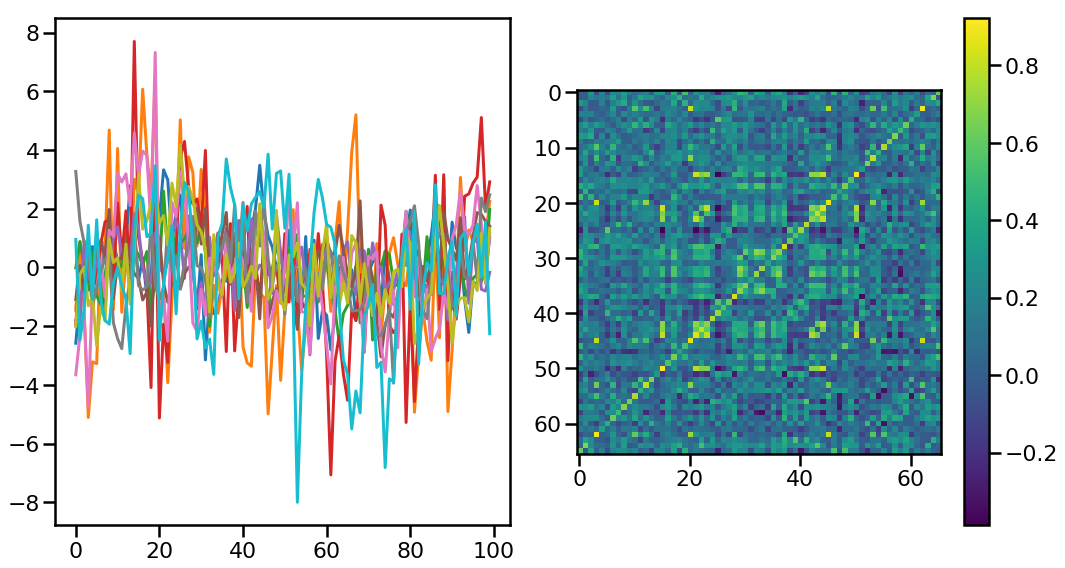

In [6]:
# load data
movie = np.load('ts_emp.npy')
# plot time series
plt.subplot(1, 2, 1)
toplot = movie[0, 0, :10, :].T - np.mean(movie[0, 0, :10, :], axis=1)[:, np.newaxis].T
plt.plot(toplot[:100, :])
# show covariance
pearson = np.corrcoef(movie[0, 0, :, :])
np.fill_diagonal(pearson, 0)
plt.subplot(1, 2, 2)
plt.imshow(pearson)
plt.colorbar()
plt.tight_layout()
plt.show()

## Estimating connectivity for all sessions and putting them all together

In [65]:
n_subj = movie.shape[0]
n_sess = movie.shape[1]
n_rois = movie.shape[2]
FC = np.zeros([n_subj*n_sess, int(n_rois*(n_rois-1)/2)])
i = 0
for sub in range(n_subj):
    for sess in range(n_sess):
        FCtmp = np.corrcoef(movie[sub, sess, :, :])
        FC[i, :] = FCtmp[np.tril_indices_from(FCtmp, k=-1)]
        i += 1
n_subj = 22
n_sess = 5
labels = np.array([0 if j<3 else 1 for i in range(n_subj) for j in range(n_sess)])
print("Shape of FC is: %d, %d" %(FC.shape))
print("Shape of labels is: %d" %y.shape)

Shape of FC is: 110, 2145
Shape of labels is: 44


## Connectivity estimation as feature engineering

       
$~$
$~$
$~$
         
<center>
    
<img src="pipeline.png" alt="" width="800"/>

<center>

## Connectomes are multidimensional objects

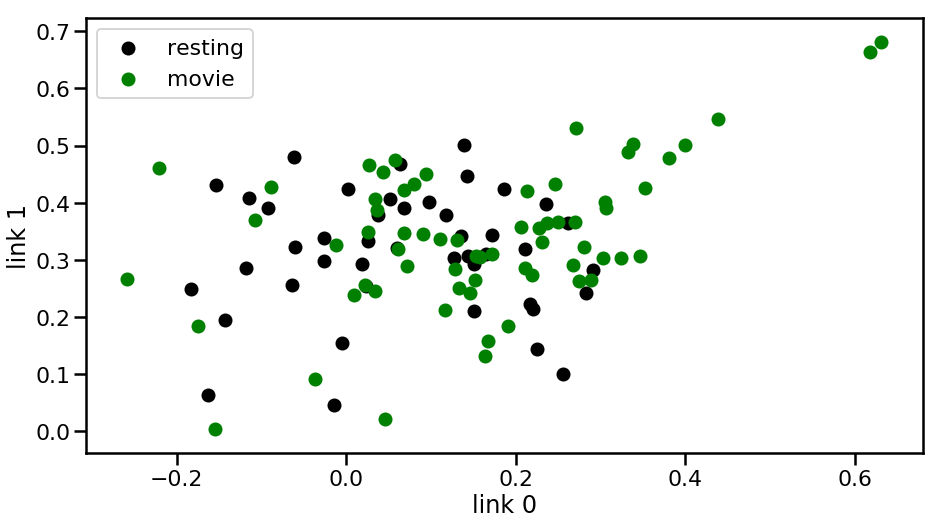

In [8]:
plt.scatter(FC[y==1, 0], FC[y==1, 1], label='resting', color='k')
plt.scatter(FC[y==0, 0], FC[y==0, 1], label='movie', color='g')
plt.xlabel('link 0')
plt.ylabel('link 1')
plt.legend()
plt.show()

## Classification based on functional connectivity

* linear model (simple is better than complex):
$$ Pr(C=1 | \mathbf{x}) = \sigma(\sum_{j=0}^M \beta_j x_j)$$

In [69]:
from sklearn.linear_model import LogisticRegression

mask = np.array([True if j==0 or j==4 else False for i in range(n_subj) for j in range(n_sess)])
X, y = (FC[mask, :], labels[mask])
model = LogisticRegression(C=10000, solver='lbfgs')
model.fit(X, y)
print("Shape of X is: %d, %d" %X.shape)
print("Fraction of correct classification: %.2f" %model.score(X, y))

Shape of X is: 44, 2145
Fraction of correct classification: 1.00


## Cross-validation

Estimating the prediction error on new data.

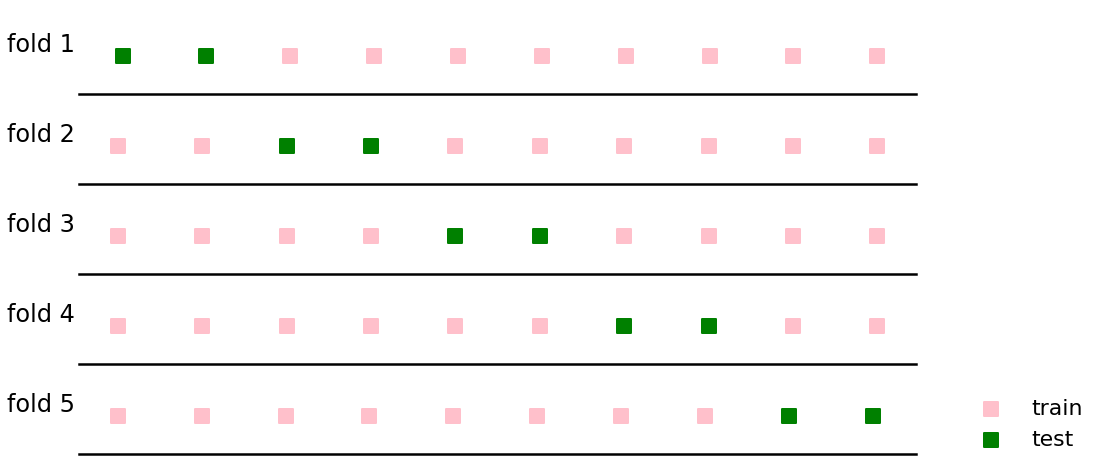

In [10]:
from conn_utils import plot_CVfold
N = 10
tmpX = np.arange(N)
n_folds = 5
kf = KFold(n_splits=n_folds)
i = 0
for train, test in kf.split(tmpX):
    plot_CVfold(n_folds, tmpX, train, test, i)
    i += 1
plt.legend(frameon=False, bbox_to_anchor=(1.04, 1))
plt.show()

## Putting it all together

In [56]:
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True)
scores = np.zeros([n_folds])
for i, (train_idx, test_idx) in enumerate(kf.split(X)):
    model.fit(X[train_idx, :], y[train_idx])
    scores[i] = model.score(X[test_idx, :], y[test_idx])
print("Fraction of correct classification in test-set: %.2f +/- %.3f" %(scores.mean(), scores.std()))

Fraction of correct classification in test-set: 0.97 +/- 0.075


## What does this tell us about the brain?

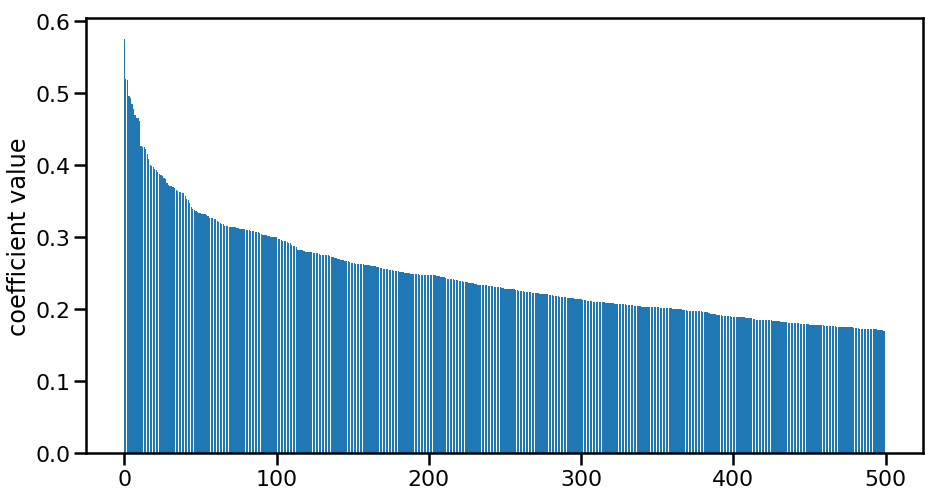

In [57]:
sorting = np.argsort(-np.abs(model.coef_[0]))
plt.bar(np.arange(500), np.abs(model.coef_[0][sorting][:500]))
plt.ylabel("coefficient value")
plt.show()

## Further readings

* Pallarés et al. (Neuroimage, 2018), Extracting orthogonal subject- and condition-specific signatures from fMRI data using whole-brain effective connectivity.


* Benitez-Stultz et al. (BioRxiv, 2018), Comparing Task-Relevant Information Across Different Methods of Extracting Functional Connectivity.




# Thank you!